In [1]:
import numpy as np
import json
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchattacks import *

from utils import *

from tqdm import tqdm
# from utils import imshow, image_folder_custom_label

In [14]:
Batch_size = 100
thr = 10000

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [6]:
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
val_dataset = torchvision.datasets.ImageNet(root="./dataset", split='val',transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=5)

# load model

In [7]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [8]:
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [9]:
model = nn.Sequential(
    norm_layer,
    models.resnet18(pretrained=True)
).to(device)
model = model.eval()

In [10]:
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
train_dataset = torchvision.datasets.ImageNet(root="./dataset", split='train',transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=5)

In [24]:
atk = FGSM(model, eps=8/255)
atk = CW(model, c=1, lr=0.01, steps=100, kappa=0)

In [25]:
idx = 0
Y_sen_list = np.empty([0, 8, 8])
Cb_sen_list = np.empty([0, 8, 8])
Cr_sen_list = np.empty([0, 8, 8])

for images, labels in tqdm(train_loader):
    img_shape = images.shape[-2:]
    images, labels = images.to(device), labels.to(device)
    # generate adv images
    adv_images = atk(images, labels)
    # adv_images = images
    # DCT 
    ycbcr_adv_images = rgb_to_ycbcr(adv_images)
    input_adv_DCT_block_batch = block_dct(blockify(ycbcr_adv_images, 8))
    input_adv_DCT_block_batch.requires_grad = True
    recoverd_adv_img = deblockify(block_idct(input_adv_DCT_block_batch), (img_shape[0], img_shape[1]))
    # feed the attack to DNN
    outputs = model(ycbcr_to_rgb(recoverd_adv_img))
    _, pre = torch.max(outputs.data, 1)
    loss = torch.nn.CrossEntropyLoss()(outputs, pre)
    model.zero_grad()
    loss.backward()
    data_grad = torch.mean(torch.abs(input_adv_DCT_block_batch.grad), dim = 2).transpose(1,0).detach().cpu().numpy()
    Y_sen_list = np.concatenate((Y_sen_list, data_grad[0].reshape(-1, 8, 8)))
    Cb_sen_list = np.concatenate((Cb_sen_list, data_grad[1].reshape(-1, 8, 8)))
    Cr_sen_list = np.concatenate((Cr_sen_list, data_grad[2].reshape(-1, 8, 8)))
    idx += Batch_size
    if idx >= thr:
        break

  0%|          | 37/128117 [02:22<136:32:31,  3.84s/it]


KeyboardInterrupt: 

100%|██████████| 64/64 [00:00<00:00, 262.47it/s]


Y [0.002631900982190667, 0.0030859653803586083, 0.002906013741359416, 0.002808156576818478, 0.002930552601619551, 0.0029706762755768983, 0.002927168643272616, 0.002934986122559495, 0.003024940873232668, 0.003007637687282911, 0.0031623652990448213, 0.0031157463480238684, 0.003210504787717974, 0.003052459172120829, 0.0031103745457512822, 0.0028469304647120884, 0.0030224059391565725, 0.003133081879520245, 0.0030986995156349847, 0.0031500829659241074, 0.0028455875498498823, 0.002355411637985399, 0.002838314944894558, 0.003043880783198544, 0.0030500721161862547, 0.0030607878602395278, 0.002917152764050688, 0.002390948845243653, 0.0013433956159070554, 0.0025118183125985762, 0.002794590609525348, 0.0030395736069696185, 0.003045993353952928, 0.003241595707150062, 0.00257894872978215, 0.0014491088261762157, 0.0018875275421599332, 0.002634281878898502, 0.002952527124194179, 0.0029892408908820537, 0.002798657858495692, 0.002590373136636572, 0.0016377840062096112, 0.0018881183551724473, 0.00254793

100%|██████████| 64/64 [00:00<00:00, 257.38it/s]


Cb [0.002756728284742853, 0.00191927662883528, 0.001887981229993113, 0.001588218581472807, 0.0016135419670968826, 0.0015790323724051759, 0.0011377952172605418, 0.0014862382090782777, 0.0014871875924936907, 0.0011599667399073042, 0.0009531790009951508, 0.001209386952062332, 0.0014482236258225897, 0.00117431900412487, 0.001011629775104529, 0.0008333531528509256, 0.0009597231236356499, 0.001163038157565263, 0.0012247625496549645, 0.0009325285356980734, 0.0008113279743098987, 0.0006932991533987524, 0.0008033617321877203, 0.000940910302595545, 0.0009868213624013155, 0.0008896112822427589, 0.0008636028267641671, 0.0007969640935448648, 0.0005570645359066282, 0.0008143179167508014, 0.0008805868782425509, 0.0008593577120365613, 0.0008868436876293007, 0.0008714779588688632, 0.0007909374898285084, 0.0005677216804778114, 0.0007088111904277294, 0.000846474006679292, 0.0009295105025461198, 0.0009506739069132819, 0.000900330804941369, 0.0008533429185305613, 0.0006653944939592713, 0.000760331152940537

100%|██████████| 64/64 [00:00<00:00, 276.94it/s]


Cr [0.003230314387241976, 0.0023006731535319077, 0.0022485495748873563, 0.0017495416570833058, 0.0017904857991804285, 0.0016443070298777917, 0.0012006596172321573, 0.0014881571873207584, 0.00162630170828801, 0.0011602169034962639, 0.0007663942752584919, 0.0010871300493490096, 0.0013804849971672305, 0.0011086371915512746, 0.0007310694774268824, 0.0005436038158130795, 0.0006551414195878013, 0.0010339982946805154, 0.0010229962615641265, 0.0006947270050164689, 0.0005532227179036312, 0.0004513773271966841, 0.0004979552124195459, 0.0006299777893505994, 0.0007661502467223091, 0.000580873123795865, 0.0004893982315490562, 0.000483868910071924, 0.0003915565954032054, 0.0004709682120296525, 0.0005425727984503263, 0.0005201854598622574, 0.0005584451176309817, 0.0005194552592217123, 0.0004601818549304512, 0.0003976229415865209, 0.0004031512158185317, 0.00046647839306013185, 0.00047829941503771617, 0.0005025403304015953, 0.0004852538586846367, 0.00047098121926066326, 0.00036001860474230423, 0.000398

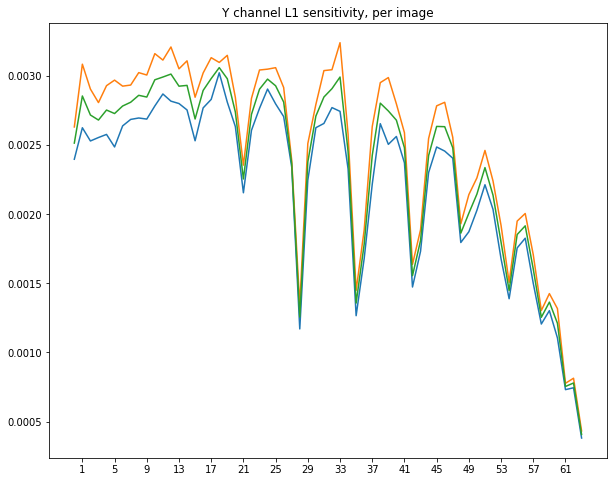

<Figure size 432x288 with 0 Axes>

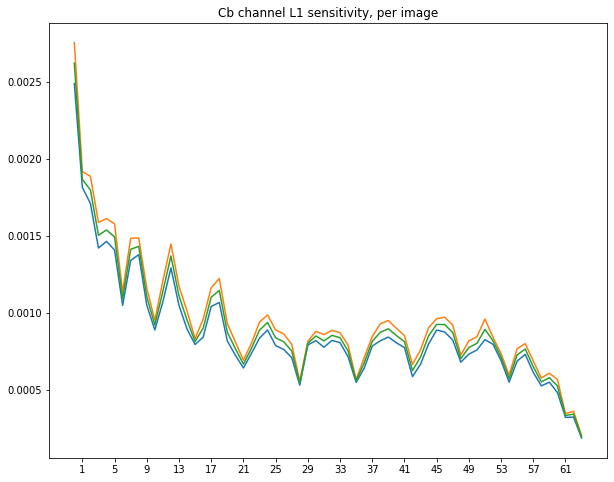

<Figure size 432x288 with 0 Axes>

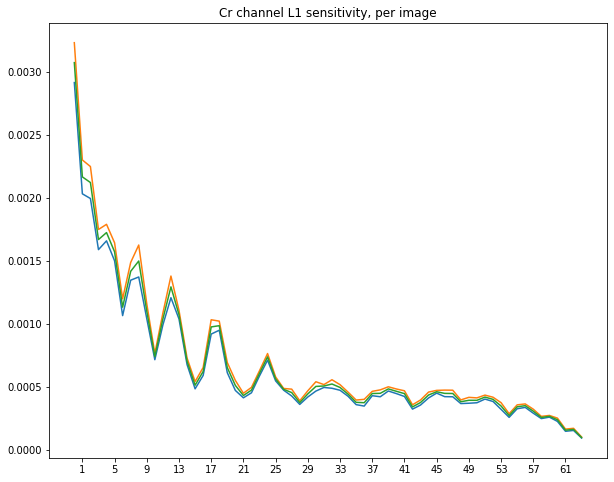

<Figure size 432x288 with 0 Axes>

In [19]:
plot_save_senmap(Y_sen_list, "Y", "Resnet18")
plot_save_senmap(Cb_sen_list, "Cb", "Resnet18")
plot_save_senmap(Cr_sen_list, "Cr", "Resnet18")

100%|██████████| 64/64 [00:00<00:00, 241.90it/s]


Y_adv [0.004415220618860696, 0.004894536435389188, 0.004688551243588944, 0.00447692834896682, 0.0046800205107190565, 0.004672932592683093, 0.004821933689427084, 0.004792879146916549, 0.0045686765526528885, 0.004825199121091582, 0.0053247285921186145, 0.004935603737103533, 0.0049829483789355115, 0.004988183637486641, 0.005102107065841224, 0.005140678548902213, 0.0051892975314019735, 0.004995664903603095, 0.005104298559434459, 0.005219994700725626, 0.005159016180106838, 0.004499875642718255, 0.005159583582622842, 0.0051656735432796495, 0.00518225641647168, 0.005079690072801109, 0.0052852003488137065, 0.004723766264320311, 0.0024640160303998375, 0.004753072524862962, 0.0051605306446355316, 0.005160394561115921, 0.0051442058238521556, 0.005390869165990126, 0.0047734100859554585, 0.0026624058820164612, 0.0034714205972803604, 0.004639191839744498, 0.0051431839142112076, 0.005182035134298372, 0.005160947382279124, 0.004775896337773997, 0.0029972133113548385, 0.00356809442759832, 0.00473896230

100%|██████████| 64/64 [00:00<00:00, 259.22it/s]


Cb_adv [0.005454679229792439, 0.003926420610077192, 0.0036709599642225036, 0.0031700344510964427, 0.003184404110741402, 0.003053261738414123, 0.002229301730352207, 0.0029625465103943357, 0.0029507994917769595, 0.0022646868434869414, 0.0018209563660123655, 0.0023126416956206256, 0.0027892040254146183, 0.0022454949783827774, 0.001845081435792461, 0.0015480504579972565, 0.0017678224371018441, 0.0022373780223778807, 0.002231441475578237, 0.0017406973631868294, 0.0014626033171054149, 0.0013303223434240718, 0.00150404911972319, 0.0016800930485944658, 0.0018151487985085268, 0.0015495366154382698, 0.0015540103657000653, 0.001535510574886793, 0.001076688188893732, 0.0015942553441649998, 0.0016557282617742247, 0.0015004654261210155, 0.0015632646158423317, 0.0015835821396183551, 0.0014559497520012783, 0.0010832361945894394, 0.0013177190715362897, 0.001553703449598695, 0.0016691254284938674, 0.0016672556248043566, 0.001659560608433308, 0.0016428873557717823, 0.0012374655818907982, 0.00140361071266

100%|██████████| 64/64 [00:00<00:00, 242.33it/s]


Cr_adv [0.0066810896295029, 0.004723522416080866, 0.004529043921161093, 0.003574970804684305, 0.003642512149367921, 0.0033716068397979075, 0.0023455521126198365, 0.003086366629090926, 0.0031546796427931153, 0.0023309138521120884, 0.0014790771402131342, 0.002189057720469278, 0.0027941437463683784, 0.0022093817798974, 0.001443209579944241, 0.0010060903266562447, 0.0012672508622015946, 0.0020016655761318446, 0.0020436426875950417, 0.001327010611674474, 0.000983648570983464, 0.0008656771921511569, 0.0009524563533927633, 0.0012075553835934124, 0.001493493513940744, 0.0011378871301907722, 0.0009479165800712879, 0.0008841021597012194, 0.0007768850526730965, 0.0008668506953394611, 0.0009726304751403437, 0.000959478605111753, 0.0010139310752752292, 0.0009610392590838582, 0.0008854852475575342, 0.0007519530658505407, 0.0007695560820143323, 0.0008803511461448428, 0.0008812170792301268, 0.0009570542750435613, 0.0009029092915822854, 0.0009201706387388437, 0.0007059479620595817, 0.000755694784084862

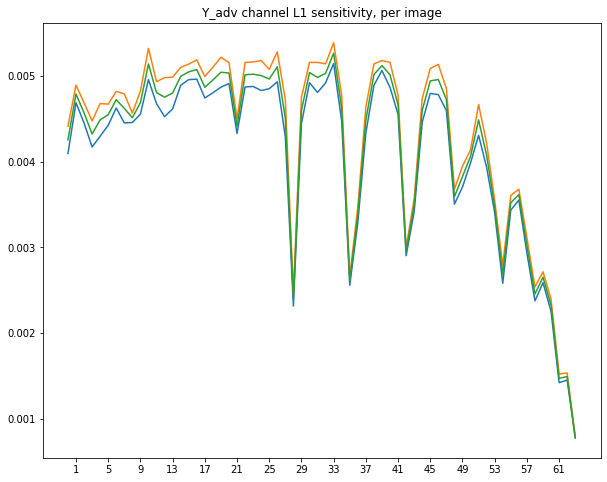

<Figure size 432x288 with 0 Axes>

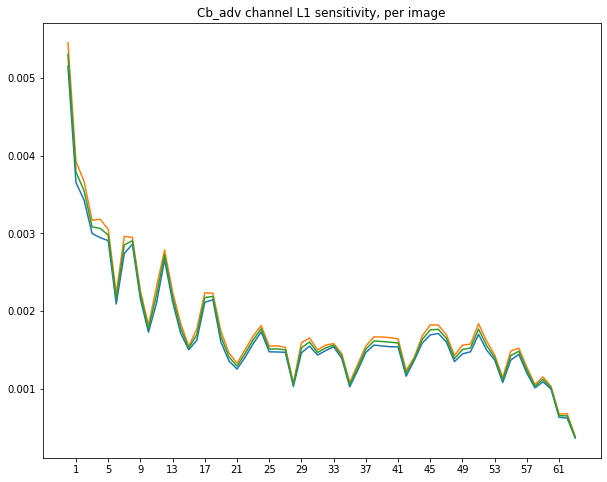

<Figure size 432x288 with 0 Axes>

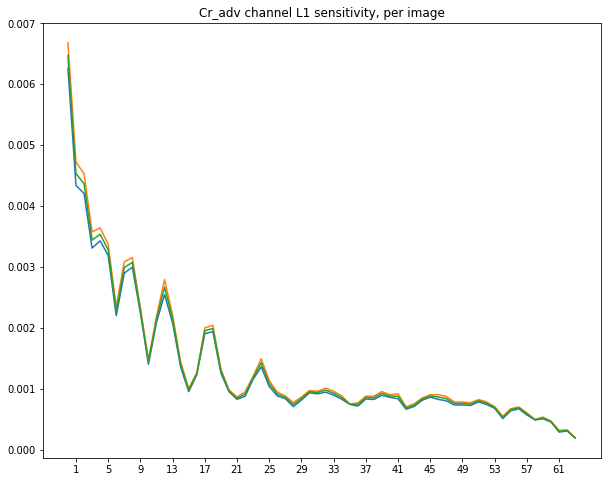

<Figure size 432x288 with 0 Axes>

In [17]:
plot_save_senmap(Y_sen_list, "Y_adv", "Resnet18")
plot_save_senmap(Cb_sen_list, "Cb_adv", "Resnet18")
plot_save_senmap(Cr_sen_list, "Cr_adv", "Resnet18")

In [21]:
ymean = [0.0025150925192657806, 0.002856051030918112, 0.0027182311044685412, 0.0026817611542513603, 0.0027542112971579626, 0.0027289270645300817, 0.0027833326917527206, 0.002810700338728468, 0.0028608179508539345, 0.002848188513790775, 0.0029730675588594616, 0.002993082178203898, 0.003014514211320849, 0.00292685201503058, 0.002932601876068601, 0.0026893966245010613, 0.0028960907768760683, 0.002982167075680091, 0.0030611931562291687, 0.0029806554799218146, 0.0027401268607158275, 0.002255494565599985, 0.0027227859439711575, 0.0029051811163511325, 0.002978054328917276, 0.0029298044961224502, 0.0028121117048751417, 0.002366326380844103, 0.0012568919263465463, 0.002379472902650764, 0.0027105743872455875, 0.0028484403685875045, 0.0029089582012470604, 0.002993170401868985, 0.002453406983893679, 0.0013576293317523426, 0.0017837145958592275, 0.0024257360979498925, 0.002804031568595695, 0.0027475732724782462, 0.0026808371956012138, 0.002481332825484362, 0.0015557642294633067, 0.0018102514000054482, 0.002424866117297247, 0.002635708923089254, 0.0026337765827140784, 0.002481377091235319, 0.0018634419983828865, 0.0020078929294883602, 0.0021460146295749103, 0.0023378567145918476, 0.0021382150774120006, 0.0017979398225631315, 0.0014482054204036727, 0.0018536755424334752, 0.0019162741407453112, 0.0016032907474078971, 0.001254572551732435, 0.0013644165506928184, 0.0012116516058172698, 0.0007540887152200062, 0.0007791426036605773, 0.0004067061850837884]


In [22]:
Y_adv = [0.004255530534018637, 0.004791848715650927, 0.004571132552082969, 0.004324729708171666, 0.004488966418478122, 0.004549450968388772, 0.0047250297392073745, 0.004623014108154016, 0.004513635063358654, 0.004690368347590951, 0.0051421461234177615, 0.004807109816077175, 0.004754826982504063, 0.004802762587729312, 0.004997519755429767, 0.005049852948465302, 0.005077172641450041, 0.004870293042772643, 0.004955053026593034, 0.0050455598328785775, 0.005036496440572265, 0.004414969583334051, 0.005016619390709118, 0.005022573640486444, 0.005007183660142087, 0.004966360861708943, 0.005109514208104683, 0.004506218894165137, 0.002389453651564106, 0.004599797752354346, 0.005042185933188088, 0.004984980302533564, 0.005033042739520502, 0.005269021849403406, 0.0046231571260224435, 0.0026097744145403955, 0.0033793129895015026, 0.004488188966823847, 0.005017900528961821, 0.005123648000335465, 0.005014676721048722, 0.0046640984069563525, 0.002949915044107554, 0.0034923678322105254, 0.0046002613030095875, 0.004944776860516521, 0.004960408740681597, 0.004726584750103251, 0.003592172305857829, 0.0038261965458887236, 0.004062591863022021, 0.004488780060289545, 0.00407433054269413, 0.003475648679713688, 0.0026854998036803055, 0.003520537316134783, 0.0036158834880195253, 0.0030227365338791057, 0.0024555498810658874, 0.0026506107795816443, 0.0023230398302452045, 0.0014693184238348568, 0.0014903900327167957, 0.000782773075710907]

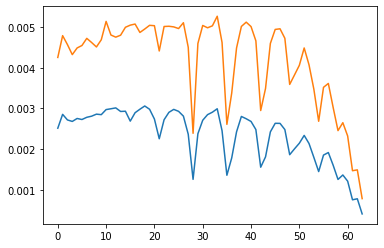

In [23]:
plt.plot(ymean)
plt.plot(Y_adv)